# GROUP 35 - STAT 301 FINAL REPORT

### Group member:
- Doris Che (33996984)
- Eric Kim (87743738)
- Naufal Prasojo (14303440)
- Isaiah Nitin (79496493)


### **2. INTRODUCTION**


We are interested to understand which listing characteristics (e.g `price`, `superhost`, etc) and location-based features (e.g `dist`, `metro_dist`, `attr_index_n`, etc) are most strongly associated with higher or lower Airbnb's `guest_satisfaction` in Athens. Our reponse variable will be `guest_satisfaction`, representing the overall guest satisfaction level of the Airbnb listing in Athens. Our question is focused on inference, as we are investing the association between the response and explanatory variables. We are not using the explanatory variables to predict what the satisfaction rating of an arbitrary listing may be.

### **3. Methods and Results**

### A) Data

**1.1 Data Summary**
- **Dataset Name:** Airbnb Prices in European Cities
- **Source:** Kaggle dataset by The Devastator (2021). Available at
https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-cities
- **License:** CC BY-NC 4.0 (Attribution-NonCommercial).
- **Data Collection:** Listings were web-scraped from Airbnb for 10 European cities (Amsterdam, Athens, Barcelona, Berlin, Budapest, Lisbon, London, Paris, Rome, Vienna), but for this assignment we only use Athens data.
     - Each city has two files (weekday and weekend) capturing snapshot prices for 2-night stays for two guests.
     - Approx. 2627~2653 observations (rows) and 19 variables (columns).

**1.2 Source and Information**

The data were collected by web-scraping Airbnb public listings around 2020–2021 by The Devastator. The author compiled cleaned CSV files for each city and time category (weekday vs weekend) and license as CC BY-NC 4.0 (Attribution-NonCommercial).

**1.3 Pre-Selection of Variables**

- Variables to keep: `guest_satisfaction_overall` (as response variable), `realSum`, `superhost`, `cleanliness_rating`, `dist`, `metro_dist`, `attr_index_norm`, `rest_index_norm`.

Reasoning: These variables seem most useful for both understanding factors for Airbnb prices or for building a model that can help estimate fair prices for future listings in Athens.

- Variables to drop (initial cleaning phase):

    - `room_type` - reflects a guest’s functional need rather than overall satisfaction, so it’s not a meaningful explanatory variable for rating differences.
    - `person_capacity` - highly correlated with other size-related features but adds little/none independent information for satisfaction.
    - `weekday/weekend` - categorical timing variable that might not relevant with overall satisfaction.
    - `lng`, `lat` – spatial coordinates does not needed for non-map models (but can be added later for spatial EDA).
    - `attr_index`, `rest_index` – very similar with normalized versions and may introduce redundancy.
    - `multi`, `biz` – may be reintroduced if host type becomes an interest variable, but initial models will focus on inference model for price.
    - `room_shared`, `room_private` – these indicators are redundant with `room_type`, so I will not include.

Reasoning: Variables dropped contain redundant or identifier information not directly useful for predictive or interpretive modelling. All decisions will be re-evaluated after EDA.

----------

### B) Exploratory Data Analysis

In [2]:
library(tidyverse)
library(broom)
library(cowplot)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: 'cowplot'


The following object is masked from 'package:lubridate':

    stamp




In [3]:
#Read data into a datafram in R
athens_weekdays_df <- read.csv("data/athens_weekdays.csv") %>% 
    mutate (is_weekend = 0)%>%
    select(guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend)

#Read data into a datafram in R
athens_weekends_df <- read.csv("data/athens_weekends.csv") %>% 
    mutate (is_weekend = 1)%>% 
    select(guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend)

# Cleaning data: removing nonsense outliers
"number obeservations for realSum >= 10000: "
nrow(athens_weekdays_df[athens_weekdays_df$realSum >= 10000,])

athens_weekdays_clean <- athens_weekdays_df %>% filter(realSum < 10000)
summary(athens_weekdays_clean$guest_satisfaction_overall)

athens_weekends_clean <- athens_weekends_df %>% filter(realSum < 10000)
summary(athens_weekends_clean$guest_satisfaction_overall)

# Combine datasets for comparison plots + add binary period column
athens <- bind_rows(
  athens_weekdays_clean %>% mutate(period = "Weekday"),
  athens_weekends_clean %>% mutate(period = "Weekend")
) %>%
  mutate(period = factor(period, levels = c("Weekday","Weekend")))

head(athens)

[1] "number obeservations for realSum >= 10000: "

[1] 1

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   20.0    94.0    97.0    95.1   100.0   100.0 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  20.00   93.00   97.00   94.91  100.00  100.00 

,guest_satisfaction_overall,realSum,dist,metro_dist,host_is_superhost,attr_index_norm,rest_index_norm,is_weekend,period
,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<fct>
1,100,129.82448,2.8139635,0.8818900,False,2.086871,5.915160,0,Weekday
2,96,138.96375,0.4072929,0.3045679,True,9.060559,30.572629,0,Weekday
3,98,156.30492,1.2372111,0.2884881,True,7.522257,29.731642,0,Weekday
4,99,91.62702,4.3674572,0.2974673,True,1.500740,4.408047,0,Weekday
5,100,74.05151,2.1941850,0.3852657,False,2.968577,8.509204,0,Weekday
6,96,113.88934,2.0712056,0.4538674,True,3.641806,11.911981,0,Weekday


In [4]:
# Visualizing the distribution of guest_satisfaction_overall for weekdays and weekends

distribution_satisfaction_weekends <- ggplot(athens_weekends_clean, aes(x = guest_satisfaction_overall)) +
    geom_histogram(bins = 30, fill = "orange", color = "white") +
    labs(title = "Distribution of Airbnb Guest Satisfaction in Athens on weekends",
        x = "Guest Satisfaction Overall",
        y = "Count") +
    theme_minimal()

distribution_satisfaction_weekdays <- ggplot(athens_weekdays_clean, aes(x = guest_satisfaction_overall)) +
    geom_histogram(bins = 30, fill = "skyblue", color = "white") +
    labs(title = "Distribution of Airbnb Guest Satisfaction in Athens on weekdays",
        x = "Guest Satisfaction Overall",
        y = "Count") +
    theme_minimal()

distribution_satisfaction_combine <- ggplot(athens, aes(x = guest_satisfaction_overall, fill = period, color = period)) +
  geom_histogram(position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Airbnb Guest Satisfaction in Athens",
        x = "Guest Satisfaction Overall",
        y = "Count") +
  scale_fill_brewer(palette = "Set2") +
  scale_color_brewer(palette = "Set2")

`stat_bin()` using `bins = 30`. Pick better value `binwidth`.
`geom_smooth()` using formula = 'y ~ x'


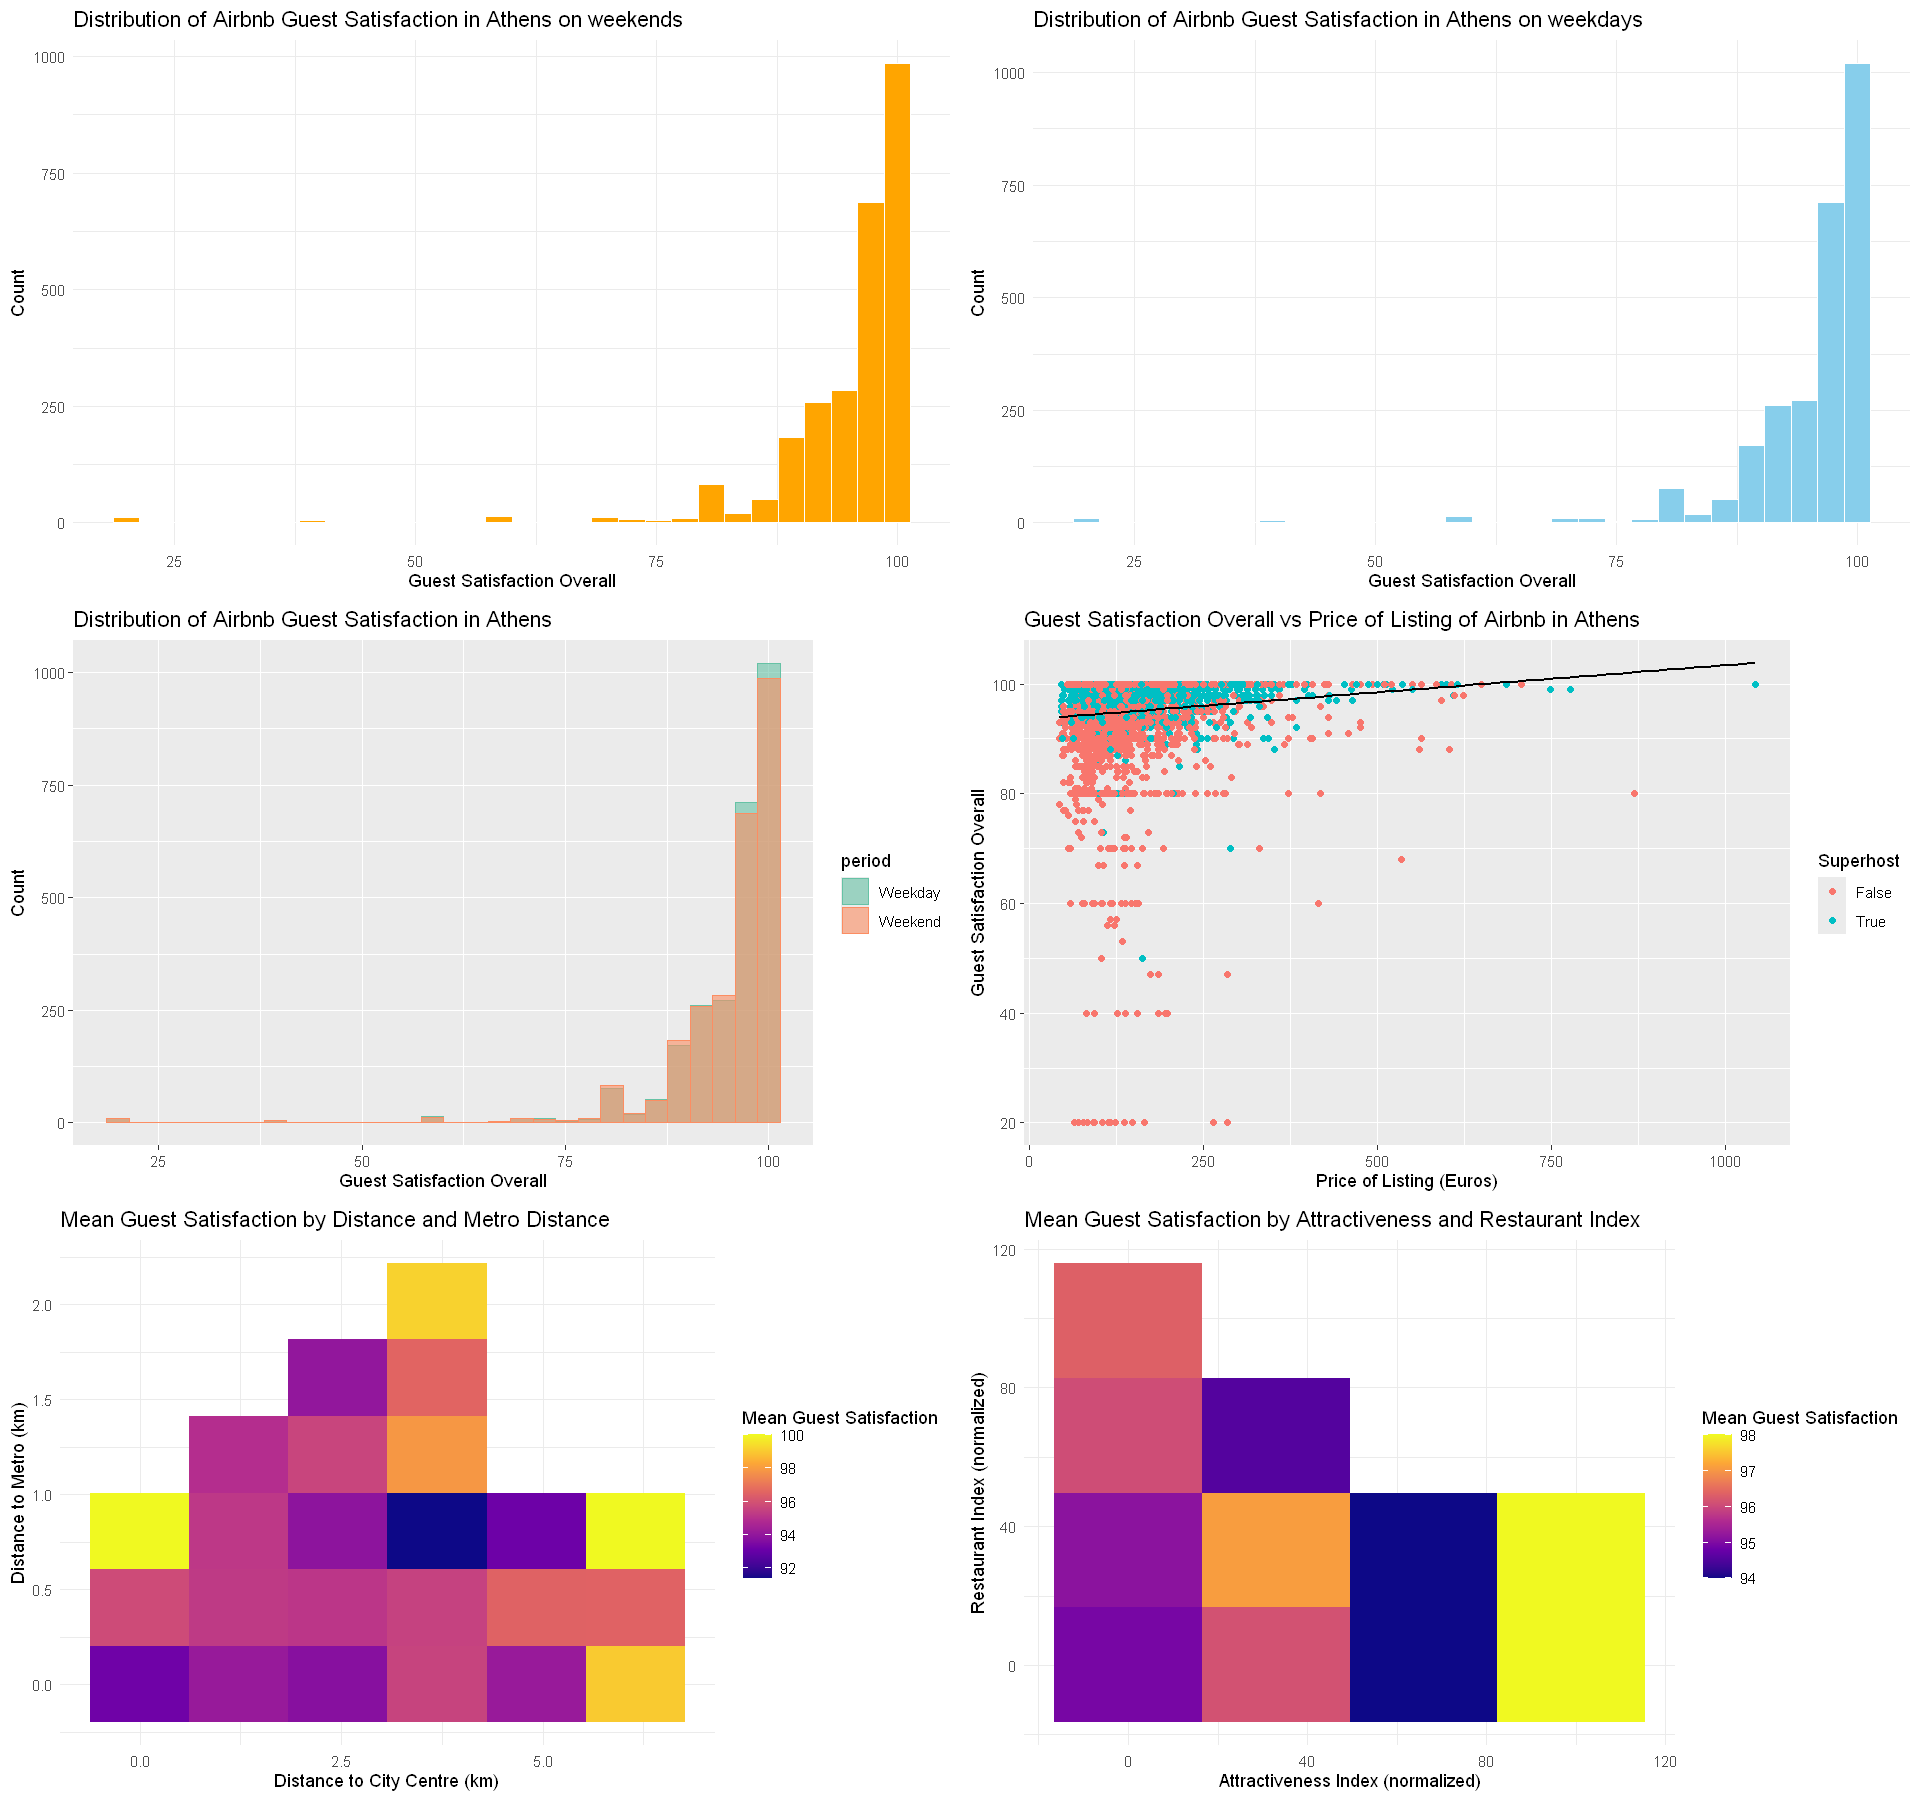

In [5]:
satis_double_dist_plot <- ggplot(athens, aes(x = dist, y = metro_dist, z = guest_satisfaction_overall)) +
  stat_summary_2d(fun = mean, bins = 6) +
  scale_fill_viridis_c(option = "C") +
  labs(title = "Mean Guest Satisfaction by Distance and Metro Distance",
       x = "Distance to City Centre (km)", y = "Distance to Metro (km)",
       fill = "Mean Guest Satisfaction") +
  theme_minimal()

satis_double_index_plot <- ggplot(athens, aes(x = attr_index_norm, y = rest_index_norm, z = guest_satisfaction_overall)) +
  stat_summary_2d(fun = mean, bins = 4) +
  scale_fill_viridis_c(option = "C") +
  labs(title = "Mean Guest Satisfaction by Attractiveness and Restaurant Index",
       x = "Attractiveness Index (normalized)", y = "Restaurant Index (normalized)",
       fill = "Mean Guest Satisfaction") +
  theme_minimal()

athens_combined_plot <- athens |>
    ggplot(aes(x = realSum, y = guest_satisfaction_overall, color = host_is_superhost)) +
           geom_point() +
           geom_smooth(method = "lm", se = FALSE, color = "black", linewidth = 0.7) +
           ggtitle("Guest Satisfaction Overall vs Price of Listing of Airbnb in Athens") +
           xlab("Price of Listing (Euros)") +
           ylab("Guest Satisfaction Overall") +
           labs(color = "Superhost")

options(repr.plot.width = 16, repr.plot.height = 15)
plot_grid(distribution_satisfaction_weekends, distribution_satisfaction_weekdays,
          distribution_satisfaction_combine, athens_combined_plot,
          satis_double_dist_plot, satis_double_index_plot,
          ncol = 2)

### C) Methods: Plan

We will be using three linear models;

1. **Simple Linear Regression** 
    * Model: guest_satisfaction_overall ~ realSum
    * Justification: The SLR baseline model will allow us to establish the association between price and guest satisfaction helping us see if higher prices correlate with guest         satisfaction before accounting for other variables that could change how the guest could feel.
2. **Multiple Linear Regression (Additive Model)**
    * Model: guest_satisfaction_overall ~ realSum + dist + metro_dist + host_is_superhost + attr_index_norm + rest_index_norm
    * Justification: The MLR is an appropriate method to understand and estimate the effect between one explanatory variable and others as constant since guest satisfaction is our response variable. This helps us decide if being a superhost increases guest satisfaction ratings with price and location as constant.
3. **Multiple Linear Regression (Interaction Model)**
    * Model: realSum x host_is_superhost
    * Justification: Using an interaction model is necessary to determine if the relationship between price and guest satisfaction depends if the host is a superhost or a regular host.

**Model Assessment and Diagnostics**

We will assess our methods by using Linear Regression Assumptions
* ***Linearity and Equal Variance*** = Residuals vs Fitted plots will help us understand how random scattered points around zero would indicate linearity and homoscedasticity assumptions are valid.
* ***Multicollinearity*** = We understand the risks of how the variables could be related to each other and hence calculating the variance inflation factor (VIF) would be of significant use.
* ***Comparing Models*** = Adjusted R^2 values to compare the fit of SLR, additive MLR and interaction models so that we do not overcrowd our data with many points.


### D) Code and Results:

#### Model 1: Simple Linear Regression:

In [6]:
model_slr <- lm(guest_satisfaction_overall ~ realSum, 
                data = athens)
table_slr <- tidy(model_slr,conf.int = TRUE, conf.lvl = 0.95)
table_slr

f_test_slr <- glance(model_slr)
f_test_slr

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),93.538623357,0.238177666,392.726257,0.000000e+00,93.071696612,94.00555010
realSum,0.009874751,0.001409075,7.007965,2.721357e-12,0.007112381,0.01263712


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.009220907,0.009033153,8.31135,49.11158,2.721357e-12,1,-18668.5,37343.01,37362.72,364527.4,5277,5279


##### Interpretation:

From the simple linear regression model with guest_satisfaction_overall as the response and realSum as the explanatory variable, we found the expected value of guest_satisfaction to be 93.53 when `realSum = 0`, which may not be directly meaningful in practice as realSum = 0 is not realistic. However with every one Euro increase in realSum, it is associated with a 0.00987 unit increase in guest satisfaction.

Observing the p-value for realSum, using a significance level of 0.05, we see that because `p.value=2.721357e-12` < 0.05, we reject the null hypothesis and conclude that there is statistically significant evidence that realSum is associated with guest_satisfaction_overall.  Although realSum may be statistically significant, it is not practically significant as its effect size is very small.

Looking at the fit of the overall model, we got an R^2 value of 0.0092, meaning that only 0.922% of the variation in guest_satisfaction_overall is explained from this model. The overall F-test is statistically significant as `p.value=2.721357e-12` < 0.05, indicating evidence of association between price and guest satisfaction, but the model explains very little of the actual variability in  guest_satisfaction_overall.

#### Model 2: Multiple Linear Regression | Additive

In [7]:
model_add <- lm(guest_satisfaction_overall ~ realSum + dist + metro_dist + host_is_superhost + attr_index_norm + rest_index_norm, 
                data = athens)

table_add <- tidy(model_add, conf.int = TRUE, conf.lvl = 0.95)
f_test_add <- glance(model_add)

table_add
f_test_add

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),91.184537232,0.529482539,172.2144369,0.000000e+00,90.146532218,92.22254225
realSum,0.008920161,0.001532735,5.8197679,6.240655e-09,0.005915366,0.01192496
dist,0.214721637,0.146612180,1.4645552,1.431019e-01,-0.072698942,0.50214222
metro_dist,0.523518973,0.401029188,1.3054386,1.918005e-01,-0.262664287,1.30970223
host_is_superhostTrue,4.266800506,0.224431595,19.0115857,5.294004e-78,3.826821651,4.70677936
attr_index_norm,-0.012625817,0.032042460,-0.3940340,6.935719e-01,-0.075442307,0.05019067
rest_index_norm,0.010252507,0.012450584,0.8234559,4.102860e-01,-0.014155793,0.03466081


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.07355844,0.07250407,8.040776,69.76517,6.472731e-84,6,-18491.29,36998.57,37051.14,340856.3,5272,5279


##### Interpretation:

From the additive multiple linear regression model, we found mean `guest_satisfaction_overall` to be **91.18** when all variables are 0, which may not be directly meaningful in practice, as it is not realistic for all covariates to be equal to 0.

`realSum`:

Holding all other variables constant, every one-euro increase in `realSum` is associated with a **0.00892-unit increase** in `guest_satisfaction_overall`. Looking at its significance, because **p = 6.24e−09 < 0.05**, we reject the null hypothesis and conclude that there is statistically significant evidence that `realSum` is associated with `guest_satisfaction_overall`.

`dist`:

Holding all other variables constant, every one-kilometer increase in `dist` is associated with a **0.2147-unit increase** in `guest_satisfaction_overall`.  
However, since **p = 0.143 > 0.05**, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that `dist` is associated with `guest_satisfaction_overall`.

`metro_dist`:

Holding all other variables constant, every one-kilometer increase in `metro_dist` is associated with a **0.525-unit increase** in `guest_satisfaction_overall`.  
Looking at the p-value, **p = 0.192 > 0.05**, so we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that `metro_dist` is associated with `guest_satisfaction_overall`.

`host_is_superhostTrue` :

Holding all other variables constant, listings by Superhosts have a `guest_satisfaction_overall` score that is **4.27 units higher** on average compared to non-Superhosts. The p-value is extremely small (**p = 5.29e−78 < 0.05**), so we reject the null hypothesis and conclude that there is **very strong evidence** that being a Superhost is associated with higher guest satisfaction.

`attr_index_norm` :

Holding all other variables constant, a one-unit increase in `attr_index_norm` is associated with a **−0.0126-unit change** in `guest_satisfaction_overall`. Since **p = 0.635 > 0.05**, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that `attr_index_norm` is associated with `guest_satisfaction_overall`.

`rest_index_norm` :

Holding all other variables constant, a one-unit increase in `rest_index_norm` is associated with a **0.0103-unit increase** in `guest_satisfaction_overall`. Because **p = 0.410 > 0.05**, we fail to reject the null hypothesis and conclude that there is no statistically significant evidence that `rest_index_norm` is associated with `guest_satisfaction_overall`.

### Overall Model Fit

The model has an **R² = 0.0736**, meaning that **7.36%** of the variation in `guest_satisfaction_overall` is explained by this additive model. The adjusted R² = **0.0725** is very similar, indicating minimal overfitting.

Looking at the overall F-test, the model p-value is **6.47e−84 < 0.05**, so we reject the null hypothesis that all slope coefficients are zero. We conclude that **at least one predictor** in the model is significantly associated with `guest_satisfaction_overall`.

---

#### Model 3: Multiple Linear Regression | Interactive (Price x Superhost)

In [8]:
model_int <- lm(guest_satisfaction_overall ~ realSum * host_is_superhost + dist + metro_dist + attr_index_norm + rest_index_norm, 
                data = athens)

model_int_results <- tidy(model_int, conf.int = TRUE, conf.lvl = 0.95)

f_test_int <- glance(model_int)

model_int_results
f_test_int

term,estimate,std.error,statistic,p.value,conf.low,conf.high
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),90.674139860,0.556012633,163.0792799,0.000000e+00,89.58412483,91.764154892
realSum,0.012331137,0.001910686,6.4537740,1.188661e-10,0.00858540,0.016076873
host_is_superhostTrue,5.503955517,0.471129049,11.6824796,3.781538e-31,4.58034746,6.427563569
dist,0.208050087,0.146519274,1.4199503,1.556813e-01,-0.07918837,0.495288545
metro_dist,0.526182700,0.400729454,1.3130622,1.892191e-01,-0.25941299,1.311778390
attr_index_norm,-0.007473968,0.032064886,-0.2330889,8.157014e-01,-0.07033442,0.055386487
rest_index_norm,0.010852906,0.012442872,0.8722187,3.831288e-01,-0.01354028,0.035246089
realSum:host_is_superhostTrue,-0.008261480,0.002766809,-2.9859240,2.840228e-03,-0.01368557,-0.002837389


r.squared,adj.r.squared,sigma,statistic,p.value,df,logLik,AIC,BIC,deviance,df.residual,nobs
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>
0.07512285,0.07389459,8.034747,61.16218,6.923486e-85,7,-18486.82,36991.65,37050.79,340280.8,5271,5279


`geom_smooth()` using formula = 'y ~ x'


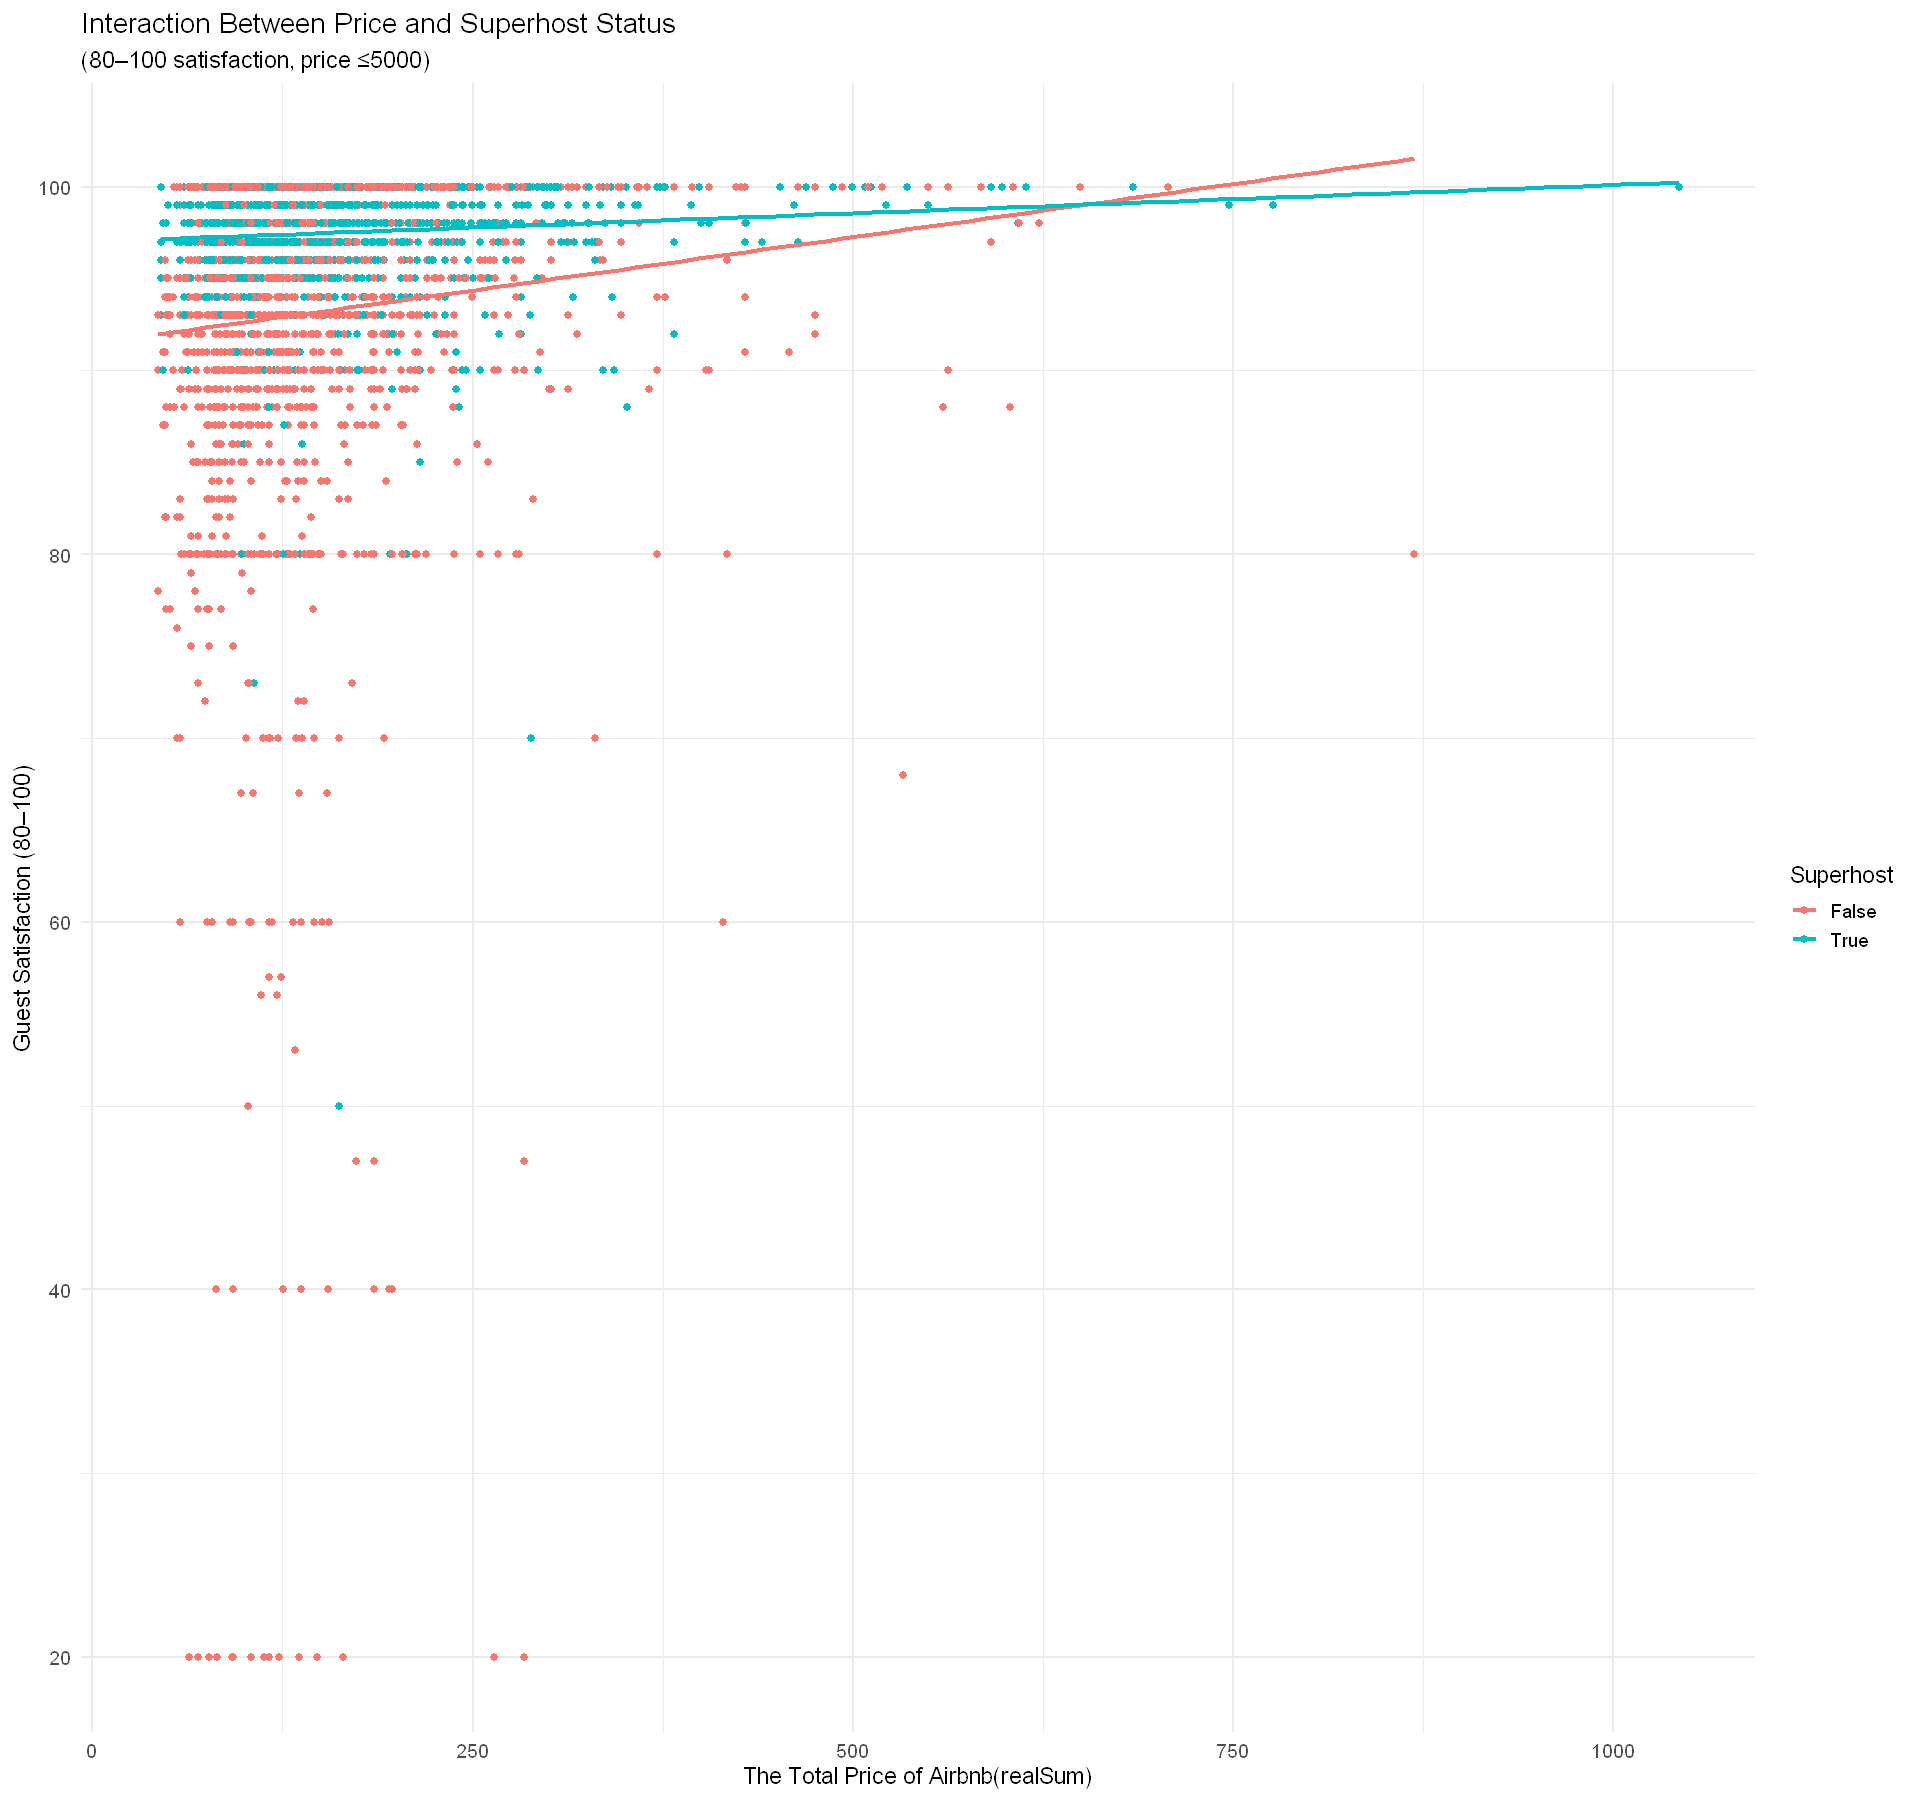

In [9]:
# Visualization of interaction effect
int_plot <- ggplot(
    athens, 
    aes(x = realSum, 
        y = guest_satisfaction_overall, 
        color = host_is_superhost))+ 
    geom_point()+ 
    geom_smooth(method = "lm", se = FALSE)+ 
    labs(title = "Interaction Between Price and Superhost Status", 
         subtitle = "(80–100 satisfaction, price ≤5000)", 
         x = "The Total Price of Airbnb(realSum)", 
         y = "Guest Satisfaction (80–100)", 
         color = "Superhost") + theme_minimal(base_size = 14)
int_plot

##### Interpretation:

From the additive multiple linear regression model with an interaction term, we found mean `guest_satisfaction_overall` to be **90.67** when all variables are 0, which again is not directly meaningful in practice, as it is unrealistic for all covariates to simultaneously be zero.

`realSum`:

Holding all other variables constant and for **non-Superhosts**, every one-euro increase in `realSum` is associated with a **0.01233-unit increase** in `guest_satisfaction_overall`. Since **p = 1.19e−10 < 0.05**, we reject the null hypothesis and conclude that `realSum` is significantly associated with `guest_satisfaction_overall` for non-Superhost listings.

`host_is_superhostTrue`:

Holding all other variables constant and at `realSum = 0`, Superhost listings have a `guest_satisfaction_overall` score that is **5.509 units higher** on average than non-Superhosts. Since **p = 3.78e−31 < 0.05**, we reject the null hypothesis and conclude that being a Superhost is significantly associated with guest satisfaction.

`dist`:

Holding all other variables constant, every one-kilometer increase in `dist` is associated with a **0.208-unit increase** in `guest_satisfaction_overall`. However, since **p = 0.156 > 0.05**, we fail to reject the null hypothesis and conclude that there is no significant evidence that `dist` is associated with `guest_satisfaction_overall`.

`metro_dist`

Holding all other variables constant, every one-kilometer increase in `metro_dist` is associated with a **0.526-unit increase** in `guest_satisfaction_overall`. Since **p = 0.183 > 0.05**, we fail to reject the null hypothesis and conclude that there is no significant evidence that `metro_dist` is associated with `guest_satisfaction_overall`.

`attr_index_norm`:

Holding all other variables constant, a one-unit increase in `attr_index_norm` is associated with a **−0.00747-unit change** in `guest_satisfaction_overall`. Since **p = 0.815 > 0.05**, we fail to reject the null hypothesis and conclude that there is no significant evidence that `attr_index_norm` is associated with `guest_satisfaction_overall`.

`rest_index_norm`:

Holding all other variables constant, a one-unit increase in `rest_index_norm` is associated with a **0.01086-unit increase** in `guest_satisfaction_overall`. Because **p = 0.383 > 0.05**, we fail to reject the null hypothesis and conclude that there is no significant evidence that `rest_index_norm` is associated with `guest_satisfaction_overall`.

`realSum:host_is_superhostTrue`:

This interaction term captures how the slope of `realSum` changes for Superhosts.  
The estimate is **−0.00883**, meaning Superhosts gain **0.00883 fewer units** of satisfaction per €1 increase in `realSum` compared to non-Superhosts. Because **p = 0.00284 < 0.05**, we reject the null hypothesis and conclude that there is significant evidence of interaction between `realSum` and `host_is_superhost`.

In practical terms, **price influences guest satisfaction differently for Superhosts than for non-Superhosts**.

### Overall Model Fit

The model has an **R² = 0.0751**, meaning that **7.51%** of the variation in `guest_satisfaction_overall` is explained by the model.  
The adjusted R² = **0.0738**, which is similar, indicating minimal overfitting.

Looking at the overall F-test, the model p-value is **6.92e−85 < 0.05**, so we reject the null hypothesis that all slope coefficients are zero. We conclude that **at least one predictor (or interaction)** in the model is significantly associated with `guest_satisfaction_overall`.

---

### 4. Discussion and Findings

**Summary**

Our results indicate that the presence of a Superhost does have a significantly correlation on airbnb guest satisfaction with its effect varying across different listing types. Although, Superhosts tend to charge **slightly higher prices on average** even after controlling for relevant variables such as room type, distance from metro, et, people are more satisfy when they book from Superhost. It suggests that having a Superhost status could serve as a sign of higher trustworthiness and comfort for customers.

Overall, the strongest and most consistent predictor of guest satisfaction across all models is **being a Superhost**, which shows a meaningful and statistically robust effect. Price (`realSum`) is statistically significant in all models but remains practically small. Distance variables and neighborhood attributes do not meaningfully explain guest satisfaction in these models. While the interactive model uncovers a nuanced difference in how price affects Superhosts, the overall explanatory power (R^2) of all models remains modest, indicating that guest satisfaction might is influenced by additional factors not captured in the dataset.

**Results compared with expectations**:
We found out that the results we obtained aligned with our expectations set at the start of the project that price and Superhosts to be meaningful factors influencing guest satisfaction. The results aligned with this expectation, as both variables showed significant associations, with Superhost status having the strongest effect.

**Areas of possible improvements**:
Aspects where we could have made slight improvements to our findings could have been taking **seasonal holiday timeline** into consideration while also including more variables such as walkability scores or proximity to landmarks as tourists would favour airbnbs with those features. Superhosts may also have potential selection bias as they might simply be better hosts in general causing the price to increase partially due to unobservable characteristics.

**Further research implications**:
We concluded that one field of particular interest could be if guests return more often to Superhost listings which would indicate stronger trust between consumer and host. Expanding our outlook into global markets to see whether culture or regional factors affect the perceived value of having a Superhost status.

### 5. Reference
Dataset used - https://www.kaggle.com/datasets/thedevastator/airbnb-prices-in-european-citiesLinks to an external site.